## Logistic Regression

C=1e-05: 0.891265646117
C=0.0001: 0.893284212784
C=0.001: 0.894867764263
C=0.01: 0.894296067544
C=0.1: 0.895057524492
C=1.0: 0.894960095149


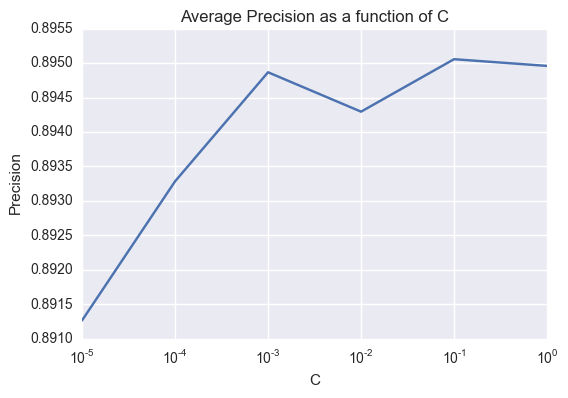

training logistic regression BIN_0
getting logistic regression predictions BIN_0
calculating logistic regression Performance on the train set: BIN_0
logistic regression train set auc: 0.903752417083
calculating logistic regression Performance on the test set: BIN_0
             precision    recall  f1-score   support

          0       0.82      0.63      0.71       508
          1       0.82      0.92      0.87       955

avg / total       0.82      0.82      0.82      1463

C=1e-05: 0.845406100004
C=0.0001: 0.851025306985
C=0.001: 0.859823075396
C=0.01: 0.863044623137
C=0.1: 0.865003281552
C=1.0: 0.86309644473


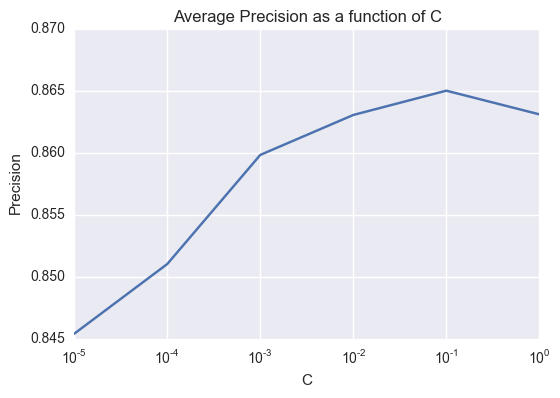

training logistic regression BIN_1
getting logistic regression predictions BIN_1
calculating logistic regression Performance on the train set: BIN_1
logistic regression train set auc: 0.869554770818
calculating logistic regression Performance on the test set: BIN_1
             precision    recall  f1-score   support

          0       0.83      0.85      0.84       860
          1       0.77      0.76      0.77       603

avg / total       0.81      0.81      0.81      1463

C=1e-05: 0.838154690803
C=0.0001: 0.846035502952
C=0.001: 0.861867845817
C=0.01: 0.877559442648
C=0.1: 0.876851631708
C=1.0: 0.873814960293


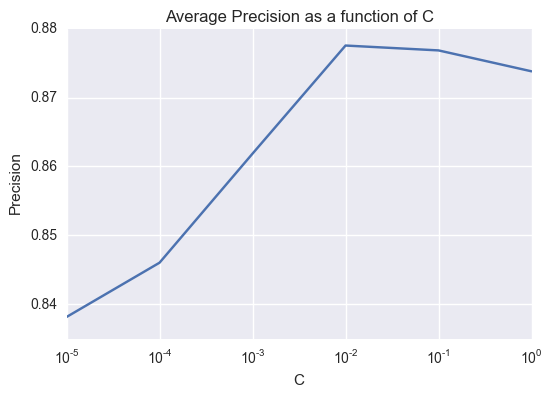

training logistic regression BIN_2
getting logistic regression predictions BIN_2
calculating logistic regression Performance on the train set: BIN_2
logistic regression train set auc: 0.878577568622
calculating logistic regression Performance on the test set: BIN_2
             precision    recall  f1-score   support

          0       0.87      0.96      0.91      1127
          1       0.80      0.53      0.64       336

avg / total       0.86      0.86      0.85      1463



In [33]:
for seperator in seperators:
    lr_train_len = train_len
    lr_labels = pp_data['likes'].apply(lambda x: 0 if x <= seperator else 1)
    lr_ids = pp_data['id']

    lr_train_set = pp_data[:lr_train_len].copy()
    lr_test_set = pp_data[lr_train_len:].copy()

    lr_train_labels = lr_labels[:lr_train_len].copy()
    lr_test_labels = lr_labels[lr_train_len:].copy()

    lr_train_ids = lr_ids[:lr_train_len].copy()
    lr_test_ids = lr_ids[lr_train_len:].copy()

    lr_train_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
    lr_test_set.drop(['likes', 'id', 'labels'], 1, inplace=True)
    lr_set = lr_train_set.append(lr_test_set, ignore_index=True)
    
    cv_scores = []
    space = np.logspace(-5,0, num=6)
    for c in space:
        res = cross_val_score(lm.LogisticRegression(penalty='l2', C=c), lr_train_set, lr_train_labels, cv=10, scoring='roc_auc')
        print "C=%s: %s" % (c, np.average(res))
        cv_scores.append(np.average(res))

    plot_cross_val(space, cv_scores, "C")
    lr_selceted_c = space[cv_scores.index(max(cv_scores))]
    
    print "training logistic regression", bin_names[seperators.index(seperator)]
    lr = lm.LogisticRegression(penalty='l2', C=lr_selceted_c)  #penalty='l2' #dual=True) #lr_selceted_c)

    lr.fit(lr_train_set, lr_train_labels)
    print "getting logistic regression predictions", bin_names[seperators.index(seperator)]
    lr_predicted_probs = lr.predict_proba(lr_set)[:, 1]
    lr_predictions = lr.predict(lr_set)

    lr_train_predicted_probs = lr_predicted_probs[:lr_train_len]
    lr_test_predicted_probs = lr_predicted_probs[lr_train_len:]

    lr_train_predictions = lr_predictions[:lr_train_len]
    lr_test_predictions = lr_predictions[lr_train_len:]

    # attach LR predictions to the data as another feature
    pp_data['lr_prediction_%s' % bin_names[seperators.index(seperator)]] = lr_predictions.copy()
    pp_data['lr_prediction_proba_%s' % bin_names[seperators.index(seperator)]] = lr_predicted_probs.copy()

    print "calculating logistic regression Performance on the train set:", bin_names[seperators.index(seperator)]
    fpr, tpr, thresholds = metrics.roc_curve(lr_train_labels, lr_train_predicted_probs)
    lr_auc = metrics.auc(fpr, tpr)
    print "logistic regression train set auc:", lr_auc
#     plotRoc(fpr, tpr, lr_auc)
    print "calculating logistic regression Performance on the test set:", bin_names[seperators.index(seperator)]
    print(metrics.classification_report(lr_test_labels, lr_test_predictions))
#     plotMetrics(lr_test_labels,lr_test_predicted_probs)


Deciding bin placements by logistic regressions binary predictions..
Got bin placements, 0 values determined by higher probability, 0 by probability sum, 8868 were definitive


ALL DATA:
[[1268  847  100    2]
 [ 341 1178  656   42]
 [ 110  695 1120  292]
 [  32  221  725 1239]]


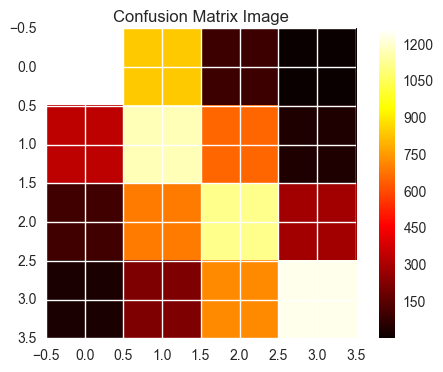

TEST SET ONLY:
[[386 213  24   0]
 [ 56 238 137  11]
 [ 13 108 152  45]
 [ 14  42 115 220]]


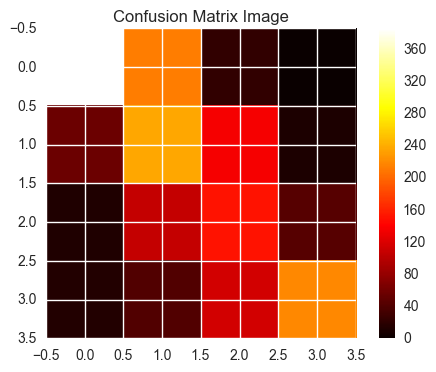

train score: 0.579903398497
train score: 0.536932619115
test score: 0.592819002579
test score: 0.561443066516


In [40]:
# unify predictions for bin classification
undef_1 = 0
undef_2 = 0

def decide_bin(row):
    global undef_1, undef_2
    preds = (row['lr_prediction_BIN_0'], row['lr_prediction_BIN_1'], row['lr_prediction_BIN_2'])
    pred_probas = (row['lr_prediction_proba_BIN_0'], row['lr_prediction_proba_BIN_1'], row['lr_prediction_proba_BIN_2'])

    if preds == (0, 0, 0):
        return 'BIN_0'
    elif preds == (1, 0, 0):
        return 'BIN_1'
    elif preds == (1, 1, 0):
        return 'BIN_2'
    elif preds == (1, 1, 1):
        return 'BIN_3'
    
    undef_1 += 1
    if preds[0] == 0 and pred_probas[0] < (1 - pred_probas[1]) and pred_probas[0] < (1 - pred_probas[2]):
        return 'BIN_0'

    if preds[2] == 1 and pred_probas[2] > (1 - pred_probas[1]) and pred_probas[2] > (1 - pred_probas[0]):
        return 'BIN_3'
    
    undef_2 += 1
    return 'BIN_%s' % int(round(sum(pred_probas)))

print "Deciding bin placements by logistic regressions binary predictions.."
bin_predictions = pp_data.apply(decide_bin, axis=1)
print "Got bin placements, %s values determined by higher probability, %s by probability sum, %s were definitive\n\n" % (undef_1, undef_2, pp_data.id.count() - undef_1 - undef_2)

print "========="
print "ALL DATA:"
print "========="
m = confusion_matrix(pp_data['labels'].values, bin_predictions.values)
print m
plotConfusion(m, 4)

print "=============="
print "TEST SET ONLY:"
print "=============="
m = confusion_matrix(pp_data['labels'][lr_train_len:].values, bin_predictions[lr_train_len:].values)
print m
plotConfusion(m, 4)

print "train score:", metrics.precision_score(pp_data['labels'][:lr_train_len], bin_predictions[:lr_train_len], average='macro')
print "train score:", metrics.precision_score(pp_data['labels'][:lr_train_len], bin_predictions[:lr_train_len], average='micro')
# print "train score:", metrics.precision_score(pp_data['labels'][:lr_train_len], bin_predictions[:lr_train_len], average='samples')
print "test score:", metrics.precision_score(pp_data['labels'][lr_train_len:], bin_predictions[lr_train_len:], average='macro')
print "test score:", metrics.precision_score(pp_data['labels'][lr_train_len:], bin_predictions[lr_train_len:], average='micro')
# print "test score:", metrics.precision_score(pp_data['labels'][lr_train_len:], bin_predictions[lr_train_len:], average='samples')

prediction_cols = ['lr_prediction_BIN_0', 'lr_prediction_BIN_1', 'lr_prediction_BIN_2', 'lr_prediction_proba_BIN_0', 'lr_prediction_proba_BIN_1', 'lr_prediction_proba_BIN_2']


## Linear Regression

### Generate preprocessed data sets (save/load from disk to save time)

In [196]:
# Getting feature selections from disk

# feat_sel_list = get_feat_sel(train_set.drop('linr_predict', 1), val_set.drop('linr_predict', 1), train_labels['likes'].apply(_log), val_labels['likes'].apply(_log), lm.LinearRegression(), verbose=True)
# with open('data_sets\LINR.json', 'w') as linrf:
#     linrf.write(json.dumps(feat_sel_list))

with open('data_sets\LINR.json', 'r') as linrf:
    feat_sel_list = json.loads(linrf.read())

get_data_sets: found threshold 0.011390625 that selected 85 feats
get_data_sets: found threshold 0.0170859375 that selected 71 feats
get_data_sets: found threshold 0.02562890625 that selected 63 feats
get_data_sets: found threshold 0.038443359375 that selected 51 feats
get_data_sets: found threshold 0.0576650390625 that selected 42 feats
get_data_sets: found threshold 0.0864975585938 that selected 32 feats
get_data_sets: found threshold 0.129746337891 that selected 27 feats


### Preprocessing - preparing different data sets and removing outliers (Grubbs) from selected features

In [201]:
linr_train_set = train_set.drop('linr_predict', 1)
linr_val_set = val_set.drop('linr_predict', 1)
linr_train_labels = train_labels.copy()
linr_val_labels = val_labels.copy()

linr_data_sets = [(linr_train_set, linr_val_set, linr_train_labels, linr_val_labels)]

for feat_sel in feat_sel_list[:3]:
    feats_to_remove_by = [feat for feat in feat_sel['selected_feats'] if set(pp_data[feat].unique()) != {-1,1}]
    linr_pp_data = grubbs_outlier_removal(pp_data, feats_to_remove_by, verbose=True)
    linr_train_len = int(linr_pp_data.shape[0] * 0.8)
    
    linr_train_labels = linr_pp_data[['likes', '4_bin_labels', '8_bin_labels']][:linr_train_len].copy()
    linr_val_labels = linr_pp_data[['likes', '4_bin_labels', '8_bin_labels']][linr_train_len:].copy()

    linr_temp_pp_data = linr_pp_data.drop(['likes', 'id', '4_bin_labels', '8_bin_labels'], 1, errors='ignore')
    linr_train_set = linr_temp_pp_data[feat_sel['selected_feats']][:linr_train_len].copy()
    linr_val_set = linr_temp_pp_data[feat_sel['selected_feats']][linr_train_len:].copy()

    linr_data_sets.append((linr_train_set, linr_val_set, linr_train_labels, linr_val_labels))

(8783, 114) (2196, 114) (8783, 3) (2196, 3)

grubbs_outlier_removal: Got 48 feats to remove outliers by. STARTING...

grubbs_outlier_removal: feat photo_avg_likes_per_photo - 80 samples removed, 10899 samples left
grubbs_outlier_removal: feat feed_min_comments - 91 samples removed, 10808 samples left
grubbs_outlier_removal: feat feed_number_of_added_photos_category - 17 samples removed, 10791 samples left
grubbs_outlier_removal: feat feed_number_of_other_categories - 80 samples removed, 10711 samples left
grubbs_outlier_removal: feat feed_avg_shares - 10 samples removed, 10701 samples left
grubbs_outlier_removal: feat feed_max_shares - 3 samples removed, 10698 samples left
grubbs_outlier_removal: feat self_feed_avg_likes_per_comment - 2 samples removed, 10696 samples left
grubbs_outlier_removal: feat self_feed_post_updated_prc - 5 samples removed, 10691 samples left
grubbs_outlier_removal: feat self_feed_min_shares - 10 samples removed, 10681 samples left
grubbs_outlier_removal: feat n

### Fit and evaluate by best feature combination

In [202]:
best_score = 0
best_score_idx = 0
for i in range(len(linr_data_sets)):
    ds = linr_data_sets[i]
    linr_train_set, linr_val_set, linr_train_labels, linr_val_labels = ds
    linr_train_labels = linr_train_labels['likes'].apply(_log)
    linr_val_labels = linr_val_labels['likes'].apply(_log)

    linr = lm.LinearRegression()
    print "training Linear regression (%s feats):" % (linr_train_set.shape[1])
    linr.fit(linr_train_set, linr_train_labels)
    print "getting Linear regression predictions"
    linr_predictions = linr.predict(linr_train_set.append(linr_val_set, ignore_index=True))

    linr_train_predictions = linr_predictions[:linr_train_set.shape[0]]
    linr_val_predictions = linr_predictions[linr_train_set.shape[0]:]

    # The coefficients
#     print 'Coefficients:'
#     coefs = linr.coef_
#     features = linr_train_set.columns.get_values().tolist()
#     lst = []
#     for i in range(len(features)):
#         lst.append((features[i], coefs[i]))
#     feat_coef = sorted(lst, key=lambda x: x[1])
#     feat_coef_str = ""
#     for a in feat_coef:
#         feat_coef_str += a[0] + ": " + str(a[1]) + "\n"
#     print feat_coef_str[:-2]

    # The mean squared error
    print "\n\nMean squared error: %.2f" %(np.mean((linr.predict(linr_train_set) - linr_train_labels) ** 2))
    # Explained variance score: 1 is perfect prediction
    print 'training variance score: %.2f' %(linr.score(linr_train_set, linr_train_labels))
    print 'validation variance score: %.2f' %(linr.score(linr_val_set, linr_val_labels))
    
    if linr.score(linr_val_set, linr_val_labels) > best_score:
        best_score = linr.score(linr_val_set, linr_val_labels)
        best_score_idx = i
        

training Linear regression (114 feats):
getting Linear regression predictions


Mean squared error: 1.01
training variance score: 0.75
validation variance score: 0.75
training Linear regression (85 feats):
getting Linear regression predictions


Mean squared error: 1.00
training variance score: 0.75
validation variance score: 0.75
training Linear regression (71 feats):
getting Linear regression predictions


Mean squared error: 1.00
training variance score: 0.75
validation variance score: 0.75
training Linear regression (63 feats):
getting Linear regression predictions


Mean squared error: 1.01
training variance score: 0.75
validation variance score: 0.75


### Best model predictions

training Linear regression (85 feats):
getting Linear regression predictions


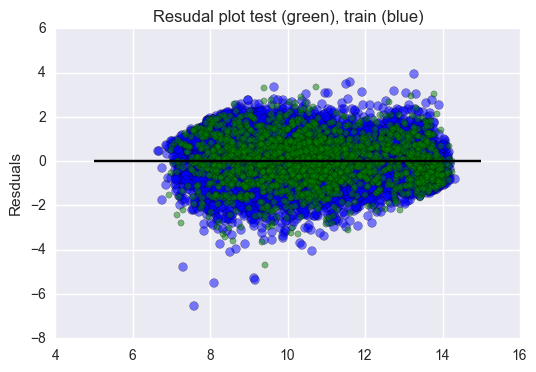

In [211]:
linr_train_set, linr_val_set, linr_train_labels, linr_val_labels = linr_data_sets[best_score_idx]

linr_val_likes = linr_val_labels['likes'].copy()
linr_train_labels = linr_train_labels['likes'].apply(_log)
linr_val_labels = linr_val_labels['likes'].apply(_log)

linr = lm.LinearRegression()
print "training Linear regression (%s feats):" % (linr_train_set.shape[1])
linr.fit(linr_train_set, linr_train_labels)
print "getting Linear regression predictions"
linr_predictions = linr.predict(linr_train_set.append(linr_val_set, ignore_index=True))

linr_train_predictions = linr_predictions[:linr_train_set.shape[0]]
linr_val_predictions = linr_predictions[linr_train_set.shape[0]:]
    
plt.scatter(linr_train_predictions, linr_train_predictions - linr_train_labels, c='b', s=40, alpha=0.5)
plt.scatter(linr_val_predictions, linr_val_predictions - linr_val_labels, c='g', alpha=0.5)
plt.hlines(y=0, xmin=5, xmax=15)
plt.title('Resudal plot test (green), train (blue)')
plt.ylabel('Resduals')
plt.show()

Linear Regression validation precision for 4 bins: 0.636832239925
LINEAR REGRESSION (4 BINS, 85 FEATS) VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.72      0.72      0.72       534
      BIN_1       0.49      0.49      0.49       533
      BIN_2       0.55      0.55      0.55       533
      BIN_3       0.78      0.78      0.78       534

avg / total       0.64      0.64      0.64      2134


Confusion matrix with 4 bins: 
[[386 133  15   0]
 [129 263 133   8]
 [ 17 118 291 107]
 [  2  19  94 419]]


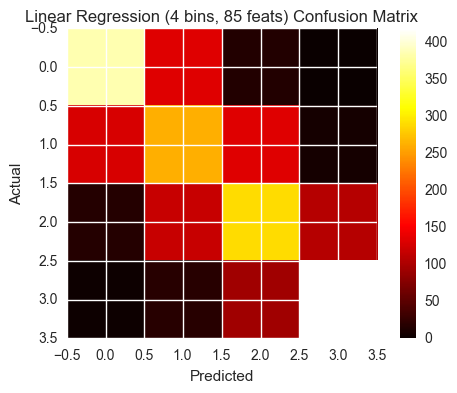


Linear Regression (4 bins, 85 feats) validation f1-score:0.636832239925
Linear Regression validation precision for 8 bins: 0.41565135895
LINEAR REGRESSION (8 BINS, 85 FEATS) VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.61      0.61      0.61       267
      BIN_1       0.36      0.36      0.36       267
      BIN_2       0.28      0.28      0.28       266
      BIN_3       0.28      0.28      0.28       267
      BIN_4       0.31      0.31      0.31       267
      BIN_5       0.32      0.32      0.32       266
      BIN_6       0.43      0.43      0.43       267
      BIN_7       0.73      0.73      0.73       267

avg / total       0.42      0.42      0.42      2134


Confusion matrix with 8 bins: 
[[163  67  27   8   2   0   0   0]
 [ 61  95  70  28  12   1   0   0]
 [ 26  55  75  69  31  10   0   0]
 [ 11  37  43  76  58  34   8   0]
 [  3   7  30  46  82  69  28   2]
 [  3   4  15  27  54  86  61  16]
 [  0  

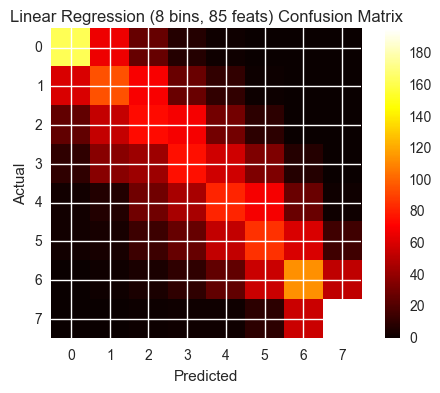


Linear Regression (8 bins, 85 feats) validation f1-score:0.41565135895

1-Bin-Away scores:
Avg Precision: 0.798924980992
Avg Recall: 0.798924980992
Avg f1-score: 0.798924980992


In [213]:
val_exp_pred = np.exp(linr_val_predictions)

for bin_num in [4,8]:
    val_pred_bins = binning(val_exp_pred, bin_num)

    linr_val_set_bin_labels = binning(linr_val_likes, bin_num)

    score = metrics.f1_score(linr_val_set_bin_labels.values, val_pred_bins, average='micro')
    print "Linear Regression validation precision for %s bins: %s" %(bin_num, score)

    run_score = eval_model("Linear Regression (%s bins, %s feats)" % (bin_num, linr_train_set.shape[1]), linr_val_set_bin_labels, val_pred_bins, None, True, bin_num)
#     m = confusion_matrix(linr_val_set_bin_labels.values, val_pred_bins)
#     print m
#     plotConfusion(m, bin_num)

### PCA run

In [ ]:
# for bin_num in (4, 8):
#     best_results_idx = scores[bin_num/4 - 1].index(max(scores[bin_num/4 - 1]))
#     linr_train_set, linr_val_set, linr_train_labels, linr_val_labels = linr_data_sets[best_results_idx]
#     linr_train_labels = linr_train_labels['%s_bin_labels' % bin_num]
#     linr_val_labels = linr_val_labels['%s_bin_labels' % bin_num]
#     linr = estimators[bin_num/4 - 1][best_results_idx]
#     linr.fit(linr_train_set, linr_train_labels)
    
#     if best_results_idx > 0:
#         feats = feat_sel_list[best_results_idx - 1]['selected_feats']
#         print "Got best results for %s selected features:\n%s" % (len(feats), '\n'.join(feats))
    
#     run_score = eval_model("Logistic Regression (%s bins, %s feats)" % (bin_num, linr_train_set.shape[0]), linr_val_labels, linr_val_predictions, linr_val_predicted_probs, True, bin_num)

In [ ]:
    
def print_ds_fields(ds):
    for feat in ds.columns.get_values():
        print "%s\t%s\t%s" % (ds.columns.get_loc(feat), ds.dtypes[ds.columns.get_loc(feat)], feat)
        
def get_data_sets_from_disk(prefix):
    import os
    import json
    import pickle
    
    files = ['data_sets\\' + filename for filename in os.listdir('data_sets') if filename.startswith(prefix)]
    
    data_sets = []
    for file_name in files:
        with open(file_name, 'r') as f:
            obj = json.loads(f.read())
            obj['data_sets'] = (pickle.loads(obj['data_sets'][0]), pickle.loads(obj['data_sets'][1]), pickle.loads(obj['data_sets'][2]), pickle.loads(obj['data_sets'][3]))
            data_sets.append(obj)
    
    return data_sets


def prepare_data(data_set, label_limit, bins=4, ids=False):
    from sklearn.utils import shuffle
    
    data_set = shuffle(data_set.copy())
    if type(label_limit) is int:
        labels = data_set['likes'].apply(lambda x: 0 if x <= label_limit else 1)
        seperators = []
    elif label_limit == 'bins':
        labels = binning(data_set['likes'], bins)
    
    train_len = int(len(data_set.id) * 0.8)

    train_ids = data_set['id'][:train_len].copy()
    test_ids = data_set['id'][train_len:].copy()

    data_set.drop(['likes', 'id', 'labels'], 1, inplace=True, errors='ignore')
    
    train_set = data_set[:train_len].copy()
    train_labels = labels[:train_len].copy()
    test_set = data_set[train_len:].copy()
    test_labels = labels[train_len:].copy()

    if ids:
        return train_set, test_set, train_labels, test_labels, train_ids, test_ids
    return train_set, test_set, train_labels, test_labels

## SVM - Binary separetors

In [21]:
svm_set = np.append(svm_train_set,svm_val_set, axis=0)

pca = PCA()
pca.fit(svm_train_set)
pca_svm_set = pca.transform(svm_set)
pca_svm_tarin_set = pca_svm_set[:train_len]
pca_svm_val_set = pca_svm_set[train_len:]

In [22]:
svm_model = svm.SVC(C=1000, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

svm_model.fit(pca_svm_tarin_set, svm_train_labels)

svm_train_pred = svm_model.predict(pca_svm_tarin_set)
train_acc = metrics.accuracy_score(svm_train_labels, svm_train_pred)

svm_val_pred = svm_model.predict(pca_svm_val_set)
val_acc = metrics.accuracy_score(svm_val_labels, svm_val_pred)


print "TRAIN ACCURACY:  " + str(train_acc)
print "=============="
print "TEST ACCURACY:  " + str(val_acc)
print "============="

TRAIN ACCURACY:  0.840564097542
TEST ACCURACY:  0.814336075206


In [27]:
svm_set = np.append(svm_train_set,svm_val_set, axis=0)

pca = PCA(80)
pca.fit(svm_train_set)
pca_svm_set = pca.transform(svm_set)
pca_svm_tarin_set = pca_svm_set[:train_len]
pca_svm_val_set = pca_svm_set[train_len:]

In [28]:
svm_model = svm.SVC(C=1000, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

svm_model.fit(pca_svm_tarin_set, svm_train_labels)

svm_train_pred = svm_model.predict(pca_svm_tarin_set)
train_acc = metrics.accuracy_score(svm_train_labels, svm_train_pred)

svm_val_pred = svm_model.predict(pca_svm_val_set)
val_acc = metrics.accuracy_score(svm_val_labels, svm_val_pred)


print "TRAIN ACCURACY:  " + str(train_acc)
print "=============="
print "TEST ACCURACY:  " + str(val_acc)
print "============="

TRAIN ACCURACY:  0.832239741455
TEST ACCURACY:  0.801801801802


### Parameter optimization 

In [ ]:
cv_scores = []
cs = []
for c in range(-12,-3):#-2,2):
    res = cross_val_score(svm.SVC(C=10**c), svm_train_set, svm_train_labels, cv=3, scoring='roc_auc')
    print "C=%s: %s" % (10**c, np.average(res))
    cs.append(10**c)
    cv_scores.append(np.average(res))
    
plot_cross_val(cs, cv_scores, "C")
svm_selceted_c = cv_scores[cv_scores.index(max(cv_scores))]

In [ ]:
cv_scores = []
cs = []
for c in range(-15,-3):
    res = cross_val_score(svm.SVC(C=10**c), svm_train_set, svm_train_labels,scoring='average_precision')
    print "C=%s: %s" % (10**c, np.average(res))
    cs.append(10**c)
    cv_scores.append(np.average(res))
    
plot_cross_val(cs, cv_scores, "C")
svm_selceted_c = cv_scores[cv_scores.index(max(cv_scores))]

#TODO: add cv for gemma

In [ ]:
from sklearn.model_selection import GridSearchCV
print("Fitting the classifier to the training set")
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['rbf', 'linear']}
clf = GridSearchCV(svm.SVC(class_weight='balanced'), param_grid)
clf = clf.fit(svm_train_set, svm_train_labels)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

### SVM run

In [ ]:
# svm_selceted_c = 16.681005372
# svm_selceted_gamma = 0.0316227766017

# svm_model = svm.SVC(probability=True, C=svm_selceted_c)#, gamma=svm_selceted_gamma)

In [19]:
svm_model = svm.SVC(C=1000, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

svm_model.fit(svm_train_set, svm_train_labels)

svm_train_pred = svm_model.predict(svm_train_set)
train_acc = metrics.accuracy_score(svm_train_labels, svm_train_pred)

svm_val_pred = svm_model.predict(svm_val_set)
val_acc = metrics.accuracy_score(svm_val_labels, svm_val_pred)


print "TRAIN ACCURACY:  " + str(train_acc)
print "=============="
print "TEST ACCURACY:  " + str(val_acc)
print "============="


TRAIN ACCURACY:  0.838605425521
TEST ACCURACY:  0.805718762241


calculating SVM Performance on the train set:
svm train set auc: 0.917719521577


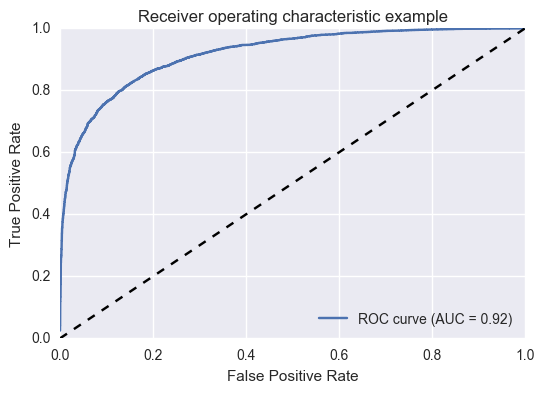

calculating SVM Performance on the test set:
svm test set auc: 0.867541870373


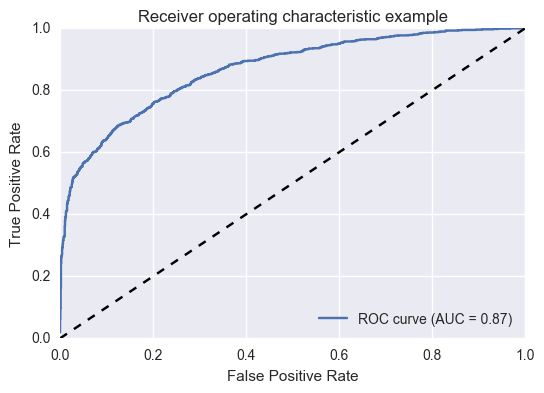

             precision    recall  f1-score   support

          0       0.82      0.86      0.84      1586
          1       0.75      0.70      0.72       967

avg / total       0.79      0.80      0.79      2553



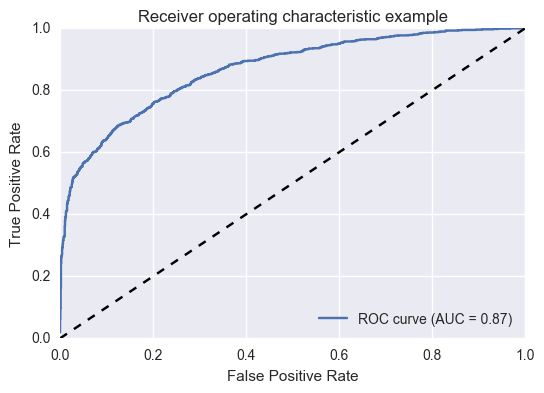

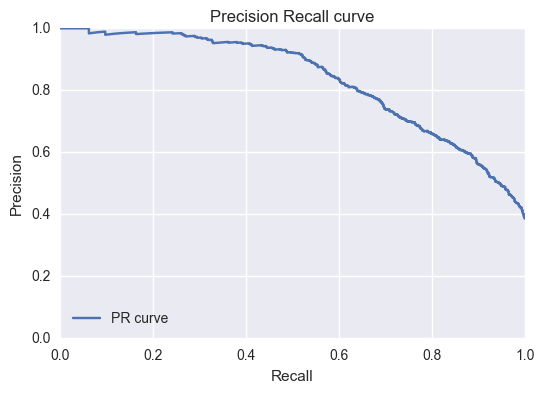

In [34]:
svm_model = svm.SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


svm_model.fit(svm_train_set, svm_train_labels)

svm_train_prediction = svm_model.predict(svm_train_set)
svm_val_prediction = svm_model.predict(svm_val_set)

svm_train_predicted_probs = svm_model.predict_proba(svm_train_set)[:, 1]
svm_val_predicted_probs = svm_model.predict_proba(svm_val_set)[:, 1]

#TODO: refactor this to genric function
print "calculating SVM Performance on the train set:"
fpr, tpr, thresholds = metrics.roc_curve(svm_train_labels, svm_train_predicted_probs)
svm_train_auc = metrics.auc(fpr, tpr)
print "svm train set auc:", svm_train_auc
plotRoc(fpr, tpr, svm_train_auc)

print "calculating SVM Performance on the test set:"
fpr, tpr, thresholds = metrics.roc_curve(svm_val_labels, svm_val_predicted_probs)
svm_val_auc = metrics.auc(fpr, tpr)
print "svm test set auc:", svm_val_auc
plotRoc(fpr, tpr, svm_val_auc)

print(metrics.classification_report(svm_val_labels, svm_val_prediction))
plotMetrics(svm_val_labels,svm_val_predicted_probs)

Fitting the classifier to the training set
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.3s finished


Best estimator found by grid search (4 bins, 29 feats):
SVC(C=0.5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.526297657327
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.5s finished


Best estimator found by grid search (4 bins, 29 feats):
SVC(C=3.7777777777777777, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.5280202113
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   14.5s finished


Best estimator found by grid search (4 bins, 29 feats):
SVC(C=7.0555555555555554, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.528249885163
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.1s finished


Best estimator found by grid search (4 bins, 29 feats):
SVC(C=10.333333333333332, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.528364722095
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.8s finished


Best estimator found by grid search (4 bins, 29 feats):
SVC(C=13.611111111111111, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.5280202113
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.7s finished


Best estimator found by grid search (4 bins, 29 feats):
SVC(C=16.888888888888889, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.527675700505
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.7s finished


Best estimator found by grid search (4 bins, 29 feats):
SVC(C=20.166666666666664, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.5280202113
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   29.0s finished


Best estimator found by grid search (4 bins, 29 feats):
SVC(C=23.444444444444443, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.528249885163
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   24.8s finished


Best estimator found by grid search (4 bins, 29 feats):
SVC(C=26.722222222222221, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.5280202113
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   36.3s finished


Best estimator found by grid search (4 bins, 29 feats):
SVC(C=30.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.527790537437


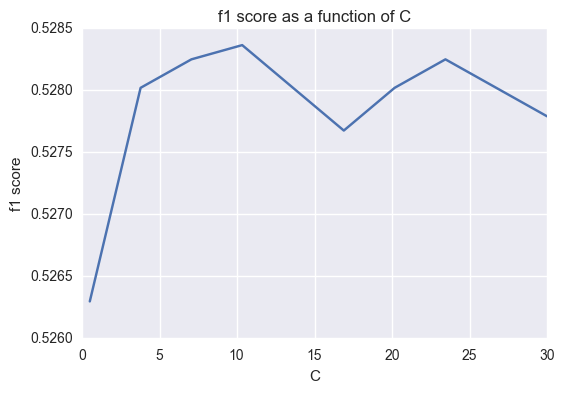

Fitting the classifier to the training set
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.1s finished


Best estimator found by grid search (8 bins, 29 feats):
SVC(C=0.5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.304892053284
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   23.8s finished


Best estimator found by grid search (8 bins, 29 feats):
SVC(C=3.7777777777777777, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.306614607258
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.4s finished


Best estimator found by grid search (8 bins, 29 feats):
SVC(C=7.0555555555555554, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.306959118052
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.5s finished


Best estimator found by grid search (8 bins, 29 feats):
SVC(C=10.333333333333332, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.306729444189
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.3s finished


Best estimator found by grid search (8 bins, 29 feats):
SVC(C=13.611111111111111, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.305925585668
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.6s finished


Best estimator found by grid search (8 bins, 29 feats):
SVC(C=16.888888888888889, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.306384933395
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   37.8s finished


Best estimator found by grid search (8 bins, 29 feats):
SVC(C=20.166666666666664, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.305925585668
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   44.8s finished


Best estimator found by grid search (8 bins, 29 feats):
SVC(C=23.444444444444443, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.305925585668
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   40.9s finished


Best estimator found by grid search (8 bins, 29 feats):
SVC(C=26.722222222222221, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.305810748737
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   40.9s finished


Best estimator found by grid search (8 bins, 29 feats):
SVC(C=30.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 0.3060404226


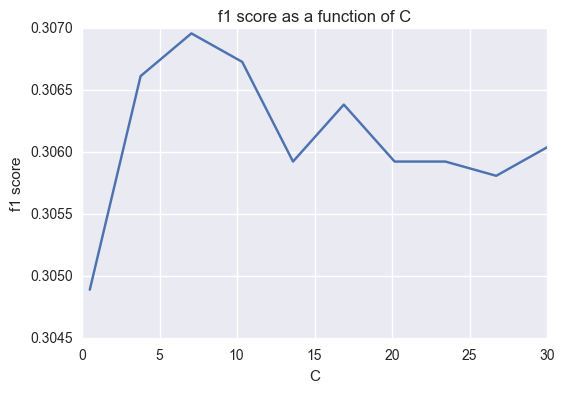

In [96]:
estimators = [[],[]]
for bin_num in (4, 8):
#     for ds in svm_data_sets:
    ds = svm_data_sets[-1]
    svm_train_set, svm_val_set, svm_train_labels, svm_val_labels = ds
    svm_train_labels = svm_train_labels['%s_bin_labels' % bin_num]
    svm_val_labels = svm_val_labels['%s_bin_labels' % bin_num]

    print("Fitting the classifier to the training set")
    scores = []
    c_range = np.linspace(0.5,30,10)
    for C in c_range:#np.logspace(-7,1, num=8):
        param_grid = {'C': [C]}
        clf = GridSearchCV(svm_lib.SVC(class_weight='balanced', kernel='linear'), param_grid, verbose=True, scoring='f1_micro')

        clf.fit(svm_train_set, svm_train_labels)
        print("Best estimator found by grid search (%s bins, %s feats):" % (bin_num, svm_train_set.shape[1]))
        print clf.best_estimator_, clf.best_score_ 
        scores.append(clf.best_score_ )
        estimators[bin_num/4 - 1].append(clf.best_estimator_)
    
    plot_results(c_range, scores, "f1 score", "C")

In [22]:
from sklearn.model_selection import GridSearchCV
print("Fitting the classifier to the training set")
param_grid = {'C': [0.01, 0.1, 1, 10], 'kernel': ['rbf', 'linear']}
clf = GridSearchCV(svm.SVC(class_weight='balanced'), param_grid)
clf = clf.fit(svm_train_set, svm_train_multi_labels)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
Best estimator found by grid search:
SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
